In [1]:
import numpy as np

from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

import dipy.reconst.dti as dti


In [2]:
from os.path import  join
fdwi = join('../DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.nii.gz')
print(fdwi)

fbval = join('../DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bval')
print(fbval)

fbvec = join('../DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bvec')
print(fbvec)

../DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.nii.gz
../DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bval
../DICOM_T1_DTI_dtionly/NII/ep2d_diff_iso2_mddw_30_p3.bvec


In [3]:
data, affine, img = load_nifti(fdwi, return_img=True)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (128, 128, 61, 136)


In [4]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (75, 94, 61, 136)


In [5]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

In [6]:
print('Computing anisotropy measures (FA, MD, RGB)')
from dipy.reconst.dti import fractional_anisotropy, color_fa

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy measures (FA, MD, RGB)


In [7]:
FA[np.isnan(FA)] = 0

In [8]:
save_nifti('../DICOM_T1_DTI_dtionly/NII/tensor_fa.nii.gz', FA.astype(np.float32), affine)

In [9]:
save_nifti('../DICOM_T1_DTI_dtionly/NII/tensor_evecs.nii.gz', tenfit.evecs.astype(np.float32), affine)

In [10]:
MD1 = dti.mean_diffusivity(tenfit.evals)
save_nifti('../DICOM_T1_DTI_dtionly/NII/tensors_md.nii.gz', MD1.astype(np.float32), affine)

In [11]:
MD2 = tenfit.md

In [12]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
save_nifti('../DICOM_T1_DTI_dtionly/NII/tensor_rgb.nii.gz', np.array(255 * RGB, 'uint8'), affine)

In [13]:
print('Computing tensor ellipsoids in a part of the splenium of the CC')

from dipy.data import get_sphere
sphere = get_sphere('repulsion724')

from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = False

scene = window.Scene()

evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]

Computing tensor ellipsoids in a part of the splenium of the CC


In [14]:
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max()

scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.3))

print('Saving illustration as tensor_ellipsoids.png')
window.record(scene, n_frames=1, out_path='tensor_ellipsoids.png',
              size=(600, 600))
if interactive:
    window.show(scene)

Saving illustration as tensor_ellipsoids.png


In [15]:
scene.clear()

In [16]:
tensor_odfs = tenmodel.fit(data[20:50, 55:85, 38:39]).odf(sphere)

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5,
                             colormap=None)
scene.add(odf_actor)
print('Saving illustration as tensor_odfs.png')
window.record(scene, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))
if interactive:
    window.show(scene)

Saving illustration as tensor_odfs.png


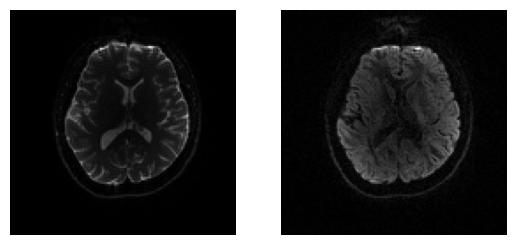

In [17]:
import matplotlib.pyplot as plt

axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

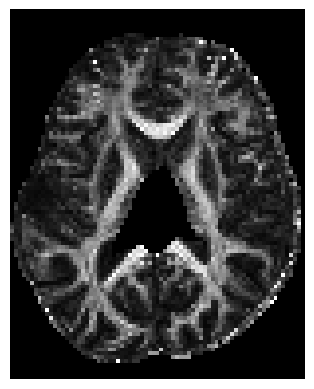

In [25]:
axial_middle = FA.shape[2] // 2
plt.figure('Showing the datasets')
plt.imshow(FA[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.axis('off')
plt.show()

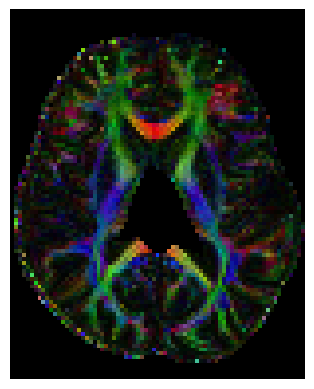

In [49]:
import matplotlib.pyplot as plt
tensor_RGB = join('../DICOM_T1_DTI_dtionly/NII/tensor_rgb.nii.gz')
data_RGB, affine, img = load_nifti(tensor_RGB, return_img=True)
axial_middle = data_RGB.shape[2] // 2
plt.figure('Showing the datasets')
plt.axis("off")
plt.imshow(np.rot90(data_RGB[:, :, axial_middle,:],3), origin='lower')
